In [ ]:
import ROOT as rt
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot

import scipy
import numpy as np
from scipy.stats import norm
import math
import sys
import os
sys.path.append(os.getcwd().replace('scripts', 'lib'))

import coffea.hist as hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)  

print(sys.version)

# Load ntuples

In [ ]:
path = '/eos/uscms/store/user/cmsdas/2025/long_exercises/MDS/data/'
data_file = path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
root_dir = uproot.open(data_file) 
tree = root_dir['MuonSystem']



# OOT Control Region Selection

Apply all the vetoes in the previous selections and require cluster time < 12.5 ns to select for the OOT validation region. 

You will replace the `REPLACE_ME` variable by `-12.5` to apply the OOT selection.

A few other selections on the cluster number of station and average station are also applied to be aligned with the analysis, which we have introduced in the `Reconstruction` episode.

Save the list of $N_\text{hits}$ and $\Delta\phi\text{(cluster, MET)}$ as numpy arrays

In [ ]:
T = tree
        
########### SELECTION: CLUSTERS ############


sel_rechitcluster = np.abs(T['cscRechitClusterEta'].array()) < 2.0

me1112_veto = 0
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberPlus11'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberPlus12'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberMinus11'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberMinus12'].array() <= me1112_veto)

sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_MB1Seg_0p4'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_RE12_0p4'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_RB1_0p4'].array() <= me1112_veto)

sel_rechitcluster = np.logical_and( sel_rechitcluster, T['cscRechitClusterJetVetoPt'].array() < 10)
sel_rechitcluster = np.logical_and( sel_rechitcluster, T['cscRechitClusterMuonVetoPt'].array() < 20)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterTimeSpread'].array() <= 20)

# OOT selection
sel_rechitcluster = np.logical_and(sel_rechitcluster,  T['cscRechitClusterTime'].array() < REPLACE_ME)



########### SELECTION: JETS ############

sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
sel_jet = np.logical_and(sel_jet, T['jetTightPassId'].array())

########### SELECTION: EVENTS ############

sel_ev = T['METTrigger'].array()
sel_ev  = np.logical_and(sel_ev,np.sum(sel_rechitcluster,axis=1) >= 1)
sel_ev = np.logical_and(sel_ev ,T['met'].array() > 200)
sel_ev = np.logical_and(sel_ev , np.sum(sel_jet,axis=1)>=1)
sel_ev = np.logical_and(sel_ev,T['metFilters'].array())


##### cut based ID ####
cscRechitClusterNStation = T['cscRechitClusterNStation'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterEta = T['cscRechitClusterEta'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterPhi = T['cscRechitClusterPhi'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterAvgStation = T['cscRechitClusterAvgStation'].array()[sel_rechitcluster][sel_ev][:,0]
cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation)==2, np.abs(cscRechitClusterEta) < 1.6)
cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation)==3, np.abs(cscRechitClusterEta) < 1.6)
cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation)==4, np.abs(cscRechitClusterEta) < 1.8)
cond1 = np.logical_and(cscRechitClusterNStation==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation)==1, cond2), np.logical_or(cond3, cond4)))
cond2 = np.logical_and(cscRechitClusterNStation > 1, np.abs(cscRechitClusterEta) < 1.9)
bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))

### Save variables needed for ABCD 

In [ ]:
deltaPhi = T['cscRechitClusterMet_dPhi'].array()[sel_rechitcluster][sel_ev][:,0][bdt_sel]
Nhits    = T['cscRechitClusterSize'].array()[sel_rechitcluster][sel_ev][:,0][bdt_sel]

## Q: Compute the correlation coefficient for $\Delta \phi$ and $N_{hits}$

The ABCD method works when the two chosen variables are independenf of each others for *background* process.   

One of the ways to quantify this is to compute the Pearson correlation coefficient $\rho$

The Pearson correlation coefficient is defined as follows:
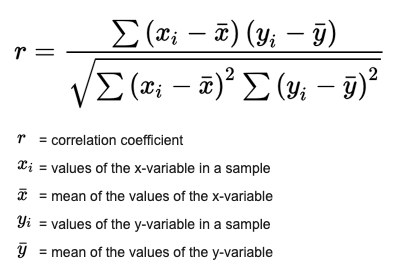

The coefficient ranges between -1 and 1 and should have a value close to 0 when the two variables are uncorrelated.
As illustrated in this figure:

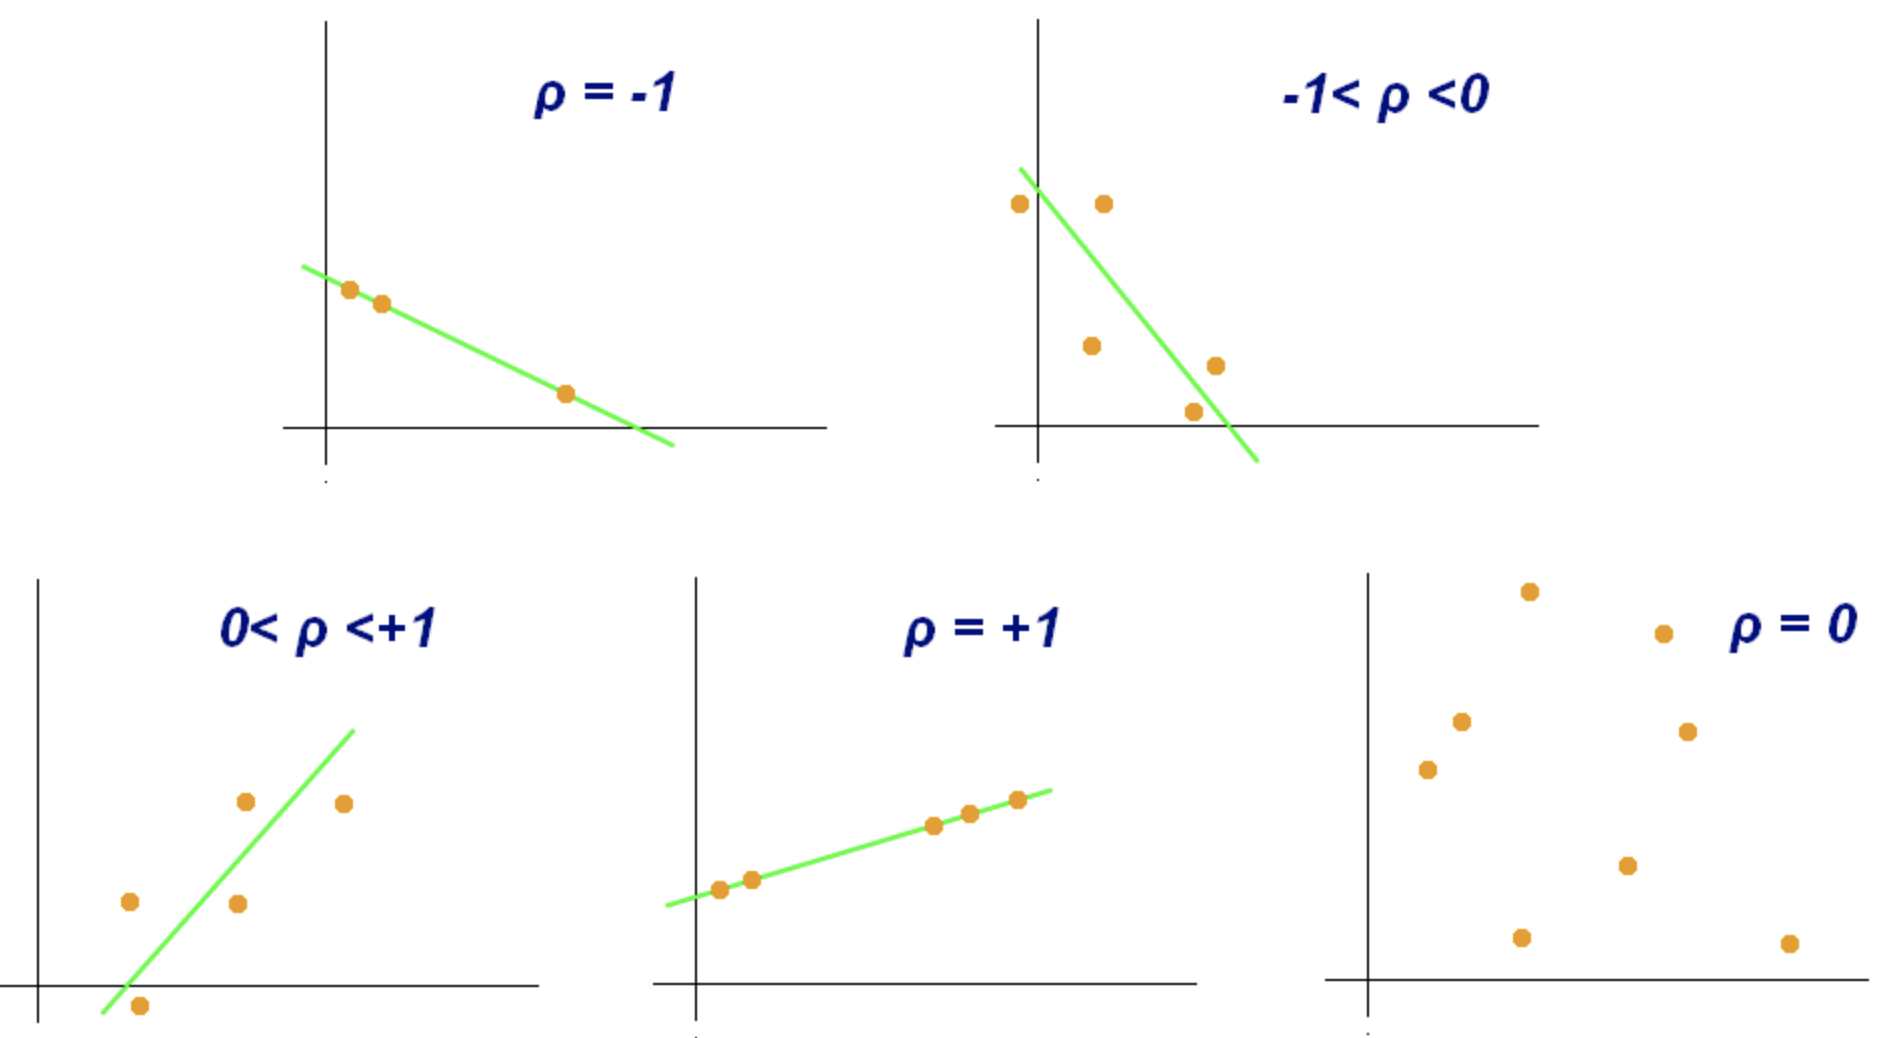

### You may use the `scipy.stats` package function to compute $\rho$ 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [ ]:
### print correlation between the two variables ####
FILL_ME

# Ex: Plot distribution of dphi and Nrechits

Plot the 2D distributions of the two variables to see if there's any obvious correlations

Write the following code:
 - Create a 2D histogram with axes named "nhits" and "dphi"
 - Fill the 2D histogram with the arrays `Nhits` and `deltaPhi`
 - Plot it with the function `hist.plot2d(h,xaxis="nhits")`

In [ ]:
plt.style.use(hep.style.CMS)

In [ ]:
# Fill the code here

# ABCD validation (Scan $N_\text{hits}$ or $\Delta\phi\mathrm{(cluster, MET)}$)

If the ABCD relationship holds across the ABCD plane, we gets more confidence in the background's behaviour.

To do so, we scan the ABCD relationship with different cuts on $N_{hits}$ and $\Delta\phi$(cluster,MET).

Here you will 
 - calculate the number of observed events in bin A, B, C, and D
 - calculate the expected background in bin A using $A = B\times C/D$
 - check if the expected background from the ABCD relation agree with the observed number of events in bin A 

### Explaination of the code

The number of observed events in bin A is already filled in.

Please complete the number of events for bin B, C, and D, where `FILL IN HERE` is indicated.

Additionally, calculate 
 - the prediction of bin A from the ABCD relationship
 - the statistical uncertainty of the prediction propogated from bin B, C, and D, by filling in `pred` and `unc_pred`

The `scan_nhits` flag determines whether we scan the threshold of $N_{hits}$ or $\Delta\phi$(cluster,MET). 

When scan_nhits = 1, we scan $N_{hits}$.

when scan_nhits = 0, we scan $\Delta\phi$(cluster,MET)

In [ ]:
scan_nhits = 1

if scan_nhits:
    dphi_scan = [0.75]
    nhits_scan = np.arange(60,200,10)
else:
    dphi_scan = np.arange(9,22,1)/20
    nhits_scan = [130]

    
print('cut \t A \t B \t C \t D \t prediction \t uncertainty')
print()
for N_RECHIT_CUT in nhits_scan:
    for DPHI_CUT in dphi_scan:
        var = np.abs(deltaPhi)
        a = np.sum(np.logical_and(Nhits>=N_RECHIT_CUT, np.abs(deltaPhi)<DPHI_CUT))
        b = FILL_ME
        c = FILL_ME
        d = FILL_ME

        pred = FILL_ME
        unc_pred = FILL_ME
        
        if scan_nhits: 
            print(N_RECHIT_CUT, '\t',a,'\t',b,'\t',c,'\t',d,'\t', round(pred, 2), '\t',round( unc_pred, 2))
        else: 
            print(DPHI_CUT, '\t',a,'\t',b,'\t',c,'\t',d,'\t', round(pred, 2), '\t', round( unc_pred, 2))
